## Import Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

%matplotlib inline

from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import KFold

### 모델 학습 graph 

In [2]:
def plot_curve(epochs, hist, list_of_metrics):
    
    fig, ax = plt.subplots(1,2,figsize = (12, 8))
    
    for i in range(len(ax)):
        ax[i].set_xlabel('Epochs')
        ax[i].set_ylabel('Value')
        
        for n in range(len(list_of_metrics)):
            if i == 0:
                y = hist[list_of_metrics[n]]
                if n == 0:
                    ax[i].plot(epochs, y, label="train")
                else:
                    ax[i].plot(epochs, y, label="val")
                ax[i].set_title('Loss')
                ax[i].legend(loc='upper right')
                if n == 1:
                    break
            else:
                if n >= 2:
                    y = hist[list_of_metrics[n]]
                    if n == 2:
                        ax[i].plot(epochs, y, label="train")
                    else:
                        ax[i].plot(epochs, y, label="val")
                    ax[i].set_title('Accuracy')
                    ax[i].legend(loc='lower right')
                    
    plt.show()

모델이 학습한 후의 그래프를 보여줍니다.  
정확도와 오차를 보기 쉽게 비교해줍니다.

### alphabet image

In [3]:
def digit_image(x):
    return np.where(x>=150, x, 0)

원본 이미지에서 숫자만 따로 추출하는 함수입니다.  
숫자 전부가 아닌 알파벳 마스크 때문에 가려진 부분은 추출되지 않을 것 입니다.

## Train

In [4]:
with open('./pickle/data.npy', 'rb') as f:
    X_trains= np.load(f)
    y_trains = np.load(f)
    TEST = np.load(f)

In [5]:
print(X_trains.shape)
print(y_trains.shape)
print(TEST.shape)

(2048, 28, 28, 3)
(2048, 10)
(20480, 28, 28, 3)


In [6]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import SeparableConv2D, Input, Conv2D, Add, BatchNormalization, concatenate, AveragePooling2D, add, MaxPooling2D 
from tensorflow.keras.layers import Conv2DTranspose, Activation, Dropout,UpSampling2D ,ZeroPadding2D, LeakyReLU
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.losses import sparse_categorical_crossentropy

In [12]:
reduction_ratio=16

### RexNet

In [13]:
def rexnet_model(shape):
    inputs = Input(shape=(28,28,3))

    conv1 = tf.keras.layers.Conv2D(filters=128, kernel_size=(5,5), kernel_initializer='he_normal', activation='elu', padding='same',
                              kernel_constraint=tf.keras.constraints.max_norm(3.))(inputs) #28x28x128


    ## Residual Unit1
    batch1_1 = tf.keras.layers.BatchNormalization()(conv1)
    elu1_1 = tf.keras.layers.ELU()(batch1_1)
    res1_1 = tf.keras.layers.Conv2D(filters=32, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu1_1) 
    batch1_2 = tf.keras.layers.BatchNormalization()(res1_1)
    elu1_2 = tf.keras.layers.ELU()(batch1_2)
    res1_2 = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu1_2) 
    batch1_3 = tf.keras.layers.BatchNormalization()(res1_2)
    elu1_3 = tf.keras.layers.ELU()(batch1_3)
    res1_3 = tf.keras.layers.Conv2D(filters=128, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu1_3)                          

    # SEBlock1
    ch_input1 = 128
    ch_reduced1 = ch_input1//reduction_ratio
    avpool1 = tf.keras.layers.GlobalAveragePooling2D()(res1_3)
    sed1_1 = tf.keras.layers.Dense(ch_reduced1, kernel_initializer='he_normal', activation='elu', use_bias=False)(avpool1)
    sed1_2 = tf.keras.layers.Dense(ch_input1, kernel_initializer='he_normal', activation='sigmoid', use_bias=False)(sed1_1)
    reshape1 = tf.keras.layers.Reshape((1,1,ch_input1))(sed1_2)
    mul1 = tf.keras.layers.Multiply()([res1_3, reshape1])
    #

    skip1 = tf.keras.layers.Conv2D(filters=128, kernel_size=(1,1), padding='same')(conv1)
    res1 = tf.keras.layers.Add()([mul1, skip1]) #28x28x128
    ##

    ## Residual Unit2
    batch2_1 = tf.keras.layers.BatchNormalization()(res1)
    elu2_1 = tf.keras.layers.ELU()(batch2_1)
    res2_1 = tf.keras.layers.Conv2D(filters=32, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu2_1) 
    batch2_2 = tf.keras.layers.BatchNormalization()(res2_1)
    elu2_2 = tf.keras.layers.ELU()(batch2_2)
    res2_2 = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu2_2) 
    batch2_3 = tf.keras.layers.BatchNormalization()(res2_2)
    elu2_3 = tf.keras.layers.ELU()(batch2_3)
    res2_3 = tf.keras.layers.Conv2D(filters=128, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu2_3)                         


    # SEBlock2
    ch_input2 = 128
    ch_reduced2 = ch_input2//reduction_ratio
    avpool2 = tf.keras.layers.GlobalAveragePooling2D()(res2_3)
    sed2_1 = tf.keras.layers.Dense(ch_reduced2, kernel_initializer='he_normal', activation='elu', use_bias=False)(avpool2)
    sed2_2 = tf.keras.layers.Dense(ch_input2, kernel_initializer='he_normal', activation='sigmoid', use_bias=False)(sed2_1)
    reshape2 = tf.keras.layers.Reshape((1,1,ch_input2))(sed2_2)
    mul2 = tf.keras.layers.Multiply()([res2_3, reshape2])
    #
    skip2 = tf.keras.layers.Conv2D(filters=128, kernel_size=(1,1), padding='same')(res1)
    res2 = tf.keras.layers.Add()([mul2, skip2])
    drop2 = tf.keras.layers.Dropout(0.3)(res2) # 28x28x128
    ##


    ## Residual Unit3
    batch3_1 = tf.keras.layers.BatchNormalization()(drop2)
    elu3_1 = tf.keras.layers.ELU()(batch3_1)
    res3_1 = tf.keras.layers.Conv2D(filters=64, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu3_1) 
    batch3_2 = tf.keras.layers.BatchNormalization()(res3_1)
    elu3_2 = tf.keras.layers.ELU()(batch3_2)
    res3_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu3_2) 
    batch3_3 = tf.keras.layers.BatchNormalization()(res3_2)
    elu3_3 = tf.keras.layers.ELU()(batch3_3)
    res3_3 = tf.keras.layers.Conv2D(filters=128, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu3_3)                           


    # SEBlock3
    ch_input3 = 128
    ch_reduced3 = ch_input3//reduction_ratio
    avpool3 = tf.keras.layers.GlobalAveragePooling2D()(res3_3)
    sed3_1 = tf.keras.layers.Dense(ch_reduced3, kernel_initializer='he_normal', activation='elu', use_bias=False)(avpool3)
    sed3_2 = tf.keras.layers.Dense(ch_input3, kernel_initializer='he_normal', activation='sigmoid', use_bias=False)(sed3_1)
    reshape3 = tf.keras.layers.Reshape((1,1,ch_input3))(sed3_2)
    mul3 = tf.keras.layers.Multiply()([res3_3, reshape3])
    #
    skip3 = tf.keras.layers.Conv2D(filters=128, kernel_size=(1,1),padding='same')(drop2)
    res3 = tf.keras.layers.Add()([mul3, skip3]) #28x28x128
    ##


    ## Residual Unit4
    batch4_1 = tf.keras.layers.BatchNormalization()(res3)
    elu4_1 = tf.keras.layers.ELU()(batch4_1)
    res4_1 = tf.keras.layers.Conv2D(filters=64, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu4_1) 
    batch4_2 = tf.keras.layers.BatchNormalization()(res4_1)
    elu4_2 = tf.keras.layers.ELU()(batch4_2)
    res4_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu4_2) 
    batch4_3 = tf.keras.layers.BatchNormalization()(res4_2)
    elu4_3 = tf.keras.layers.ELU()(batch4_3)
    res4_3 = tf.keras.layers.Conv2D(filters=256, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu4_3)                              


    # SEBlock4
    ch_input4 = 256
    ch_reduced4 = ch_input4//reduction_ratio
    avpool4 = tf.keras.layers.GlobalAveragePooling2D()(res4_3)
    sed4_1 = tf.keras.layers.Dense(ch_reduced4, kernel_initializer='he_normal', activation='elu', use_bias=False)(avpool4)
    sed4_2 = tf.keras.layers.Dense(ch_input4, kernel_initializer='he_normal', activation='sigmoid', use_bias=False)(sed4_1)
    reshape4 = tf.keras.layers.Reshape((1,1,ch_input4))(sed4_2)
    mul4 = tf.keras.layers.Multiply()([res4_3, reshape4])
    #
    skip4 = tf.keras.layers.Conv2D(filters=256, kernel_size=(1,1),padding='same')(res3)
    res4 = tf.keras.layers.Add()([mul4, skip4])
    pool4 = tf.keras.layers.MaxPool2D((2,2))(res4)
    drop4 = tf.keras.layers.Dropout(0.3)(pool4) # 14x14x256
    ##


    ## Residual Unit5
    batch5_1 = tf.keras.layers.BatchNormalization()(drop4)
    elu5_1 = tf.keras.layers.ELU()(batch5_1)
    res5_1 = tf.keras.layers.Conv2D(filters=64, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu5_1) 
    batch5_2 = tf.keras.layers.BatchNormalization()(res5_1)
    elu5_2 = tf.keras.layers.ELU()(batch5_2)
    res5_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu5_2) 
    batch5_3 = tf.keras.layers.BatchNormalization()(res5_2)
    elu5_3 = tf.keras.layers.ELU()(batch5_3)
    res5_3 = tf.keras.layers.Conv2D(filters=256, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu5_3)                                 


    # SEBlock5
    ch_input5 = 256
    ch_reduced5 = ch_input5//reduction_ratio
    avpool5 = tf.keras.layers.GlobalAveragePooling2D()(res5_3)
    sed5_1 = tf.keras.layers.Dense(ch_reduced5, kernel_initializer='he_normal', activation='elu', use_bias=False)(avpool5)
    sed5_2 = tf.keras.layers.Dense(ch_input5, kernel_initializer='he_normal', activation='sigmoid', use_bias=False)(sed5_1)
    reshape5 = tf.keras.layers.Reshape((1,1,ch_input5))(sed5_2)
    mul5 = tf.keras.layers.Multiply()([res5_3, reshape5])
    #
    skip5 = tf.keras.layers.Conv2D(filters=256, kernel_size=(1,1),padding='same')(drop4)
    res5 = tf.keras.layers.Add()([mul5, skip5])
    pool5 = tf.keras.layers.MaxPool2D((2,2))(res5) #7x7x256
    ##


    ## Residual Unit6
    batch6_1 = tf.keras.layers.BatchNormalization()(pool5)
    elu6_1 = tf.keras.layers.ELU()(batch6_1)
    res6_1 = tf.keras.layers.Conv2D(filters=64, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu6_1) 
    batch6_2 = tf.keras.layers.BatchNormalization()(res6_1)
    elu6_2 = tf.keras.layers.ELU()(batch6_2)
    res6_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu6_2) 
    batch6_3 = tf.keras.layers.BatchNormalization()(res6_2)
    elu6_3 = tf.keras.layers.ELU()(batch6_3)
    res6_3 = tf.keras.layers.Conv2D(filters=256, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu6_3)
    # SEBlock6
    ch_input6 = 256
    ch_reduced6 = ch_input6//reduction_ratio
    avpool6 = tf.keras.layers.GlobalAveragePooling2D()(res6_3)
    sed6_1 = tf.keras.layers.Dense(ch_reduced6, kernel_initializer='he_normal', activation='elu', use_bias=False)(avpool6)
    sed6_2 = tf.keras.layers.Dense(ch_input6, kernel_initializer='he_normal', activation='sigmoid', use_bias=False)(sed6_1)
    reshape6 = tf.keras.layers.Reshape((1,1,ch_input6))(sed6_2)
    mul6 = tf.keras.layers.Multiply()([res6_3, reshape6])
    #
    skip6 = tf.keras.layers.Conv2D(filters=256, kernel_size=(1,1),padding='same')(pool5)
    res6 = tf.keras.layers.Add()([mul6, skip6])
    drop6 = tf.keras.layers.Dropout(0.3)(res6) # 7x7x256
    ##

    ## Residual Unit7
    batch7_1 = tf.keras.layers.BatchNormalization()(drop6)
    elu7_1 = tf.keras.layers.ELU()(batch7_1)
    res7_1 = tf.keras.layers.Conv2D(filters=64, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu7_1) 
    batch7_2 = tf.keras.layers.BatchNormalization()(res7_1)
    elu7_2 = tf.keras.layers.ELU()(batch7_2)
    res7_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu7_2) 
    batch7_3 = tf.keras.layers.BatchNormalization()(res7_2)
    elu7_3 = tf.keras.layers.ELU()(batch7_3)
    res7_3 = tf.keras.layers.Conv2D(filters=512, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu7_3)
    skip7 = tf.keras.layers.Conv2D(filters=512, kernel_size=(1,1),padding='same')(drop6)
    res7 = tf.keras.layers.Add()([res7_3, skip7])
    pool7 = tf.keras.layers.MaxPool2D((3,3))(res7) 
    
    flatten1 = tf.keras.layers.Flatten()(pool7)
    
    dense1 = tf.keras.layers.Dense(1024, activation='elu', kernel_initializer='he_normal', kernel_constraint=tf.keras.constraints.max_norm(3.))(flatten1)
    
    drop1 = tf.keras.layers.Dropout(0.5)(dense1)
    outputs = tf.keras.layers.Dense(10 ,activation='softmax')(drop1)
    model = Model(inputs=inputs, outputs=outputs)

    return model

In [14]:
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    fill_mode='nearest'
)
datagen.fit(X_trains)

In [15]:
# 많은 데이터 셋으로 학습시키기 위해 FOLD를 100으로 설정했습니다. Fold 1 중간에 Stop시켰기에 break 조건을 넣어놨습니다.
def get_stacking(in_model, train, train_y, n_fold = 10, SEED=2020):
    k_fold = KFold(n_splits=8, shuffle=True, random_state=SEED)
    
    epochs = 500
    model_number = 0
    history = []
    batch_size = 32
    val_predict = []

    train_fold_predict = np.zeros((train.shape[0], 1))
    test_predict = []
    arm_test_predict = np.array([0]*204800).reshape(20480, 10).astype('float64')
    
    for cnt, (train_idx, val_idx) in enumerate(k_fold.split(train, train_y)):
        print(f'*******************number_{cnt+1}_kfold_model*******************')
        x_train, y_train = train[train_idx], train_y[train_idx]
        x_val, y_val = train[val_idx], train_y[val_idx]
        
        model = in_model(train.shape[1:])
        model.compile(loss="categorical_crossentropy",
                      optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07), 
                      metrics=["accuracy"])

        es = EarlyStopping(patience=15, verbose=1)
        mc = ModelCheckpoint(f'./model/model1_best_{model_number}.h5', save_best_only=True, verbose=1)
        rlp = ReduceLROnPlateau(monitor='val_loss', patience=4, factor=0.8, min_lr=0.0001)
        
        history = model.fit(datagen.flow(x_train, y_train, shuffle=True, batch_size=batch_size),
                                  epochs=epochs,
                                  validation_data=(x_val, y_val),
                                  verbose=1,
                                  steps_per_epoch=x_train.shape[0] // batch_size,
                                  validation_steps=x_val.shape[0] // batch_size,
                                  callbacks=[es, mc, rlp]
                                  )
        
#         history = model.fit(x_train, y_train, epochs = 53, validation_data=(x_val, y_val), verbose=1, batch_size = batch_size, callbacks = [es, mc, rlp])
        
        plot_curve(history.epoch, history.history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])
        
        
        model.load_weights(f'./model/model1_best_{model_number}.h5')
        pred_train = model.predict(x_val)
        pred_test = model.predict(TEST)
        
        train_fold_predict[val_idx, :] = np.argmax(pred_train, 1).reshape((x_val.shape[0], 1))
        
        test_predict.append(pred_test)
    
    for pred_test in test_predict:
        arm_test_predict += pred_test
          
    test_fold_predict = np.argmax(arm_test_predict, axis=1).reshape((TEST.shape[0], 1))
    train_fold_predict = train_fold_predict.astype('int64')
    
    return train_fold_predict, test_fold_predict

## Predict

*******************number_1_kfold_model*******************
Epoch 1/500
55/56 [============================>.] - ETA: 0s - loss: 106.7325 - accuracy: 0.1051
Epoch 00001: val_loss improved from inf to 4.77182, saving model to ./model/model1_best_0.h5
56/56 [==============================] - 3s 49ms/step - loss: 104.9105 - accuracy: 0.1083 - val_loss: 4.7718 - val_accuracy: 0.1055 - lr: 0.0010
Epoch 2/500
55/56 [============================>.] - ETA: 0s - loss: 3.9674 - accuracy: 0.1023
Epoch 00002: val_loss improved from 4.77182 to 2.35150, saving model to ./model/model1_best_0.h5
56/56 [==============================] - 2s 39ms/step - loss: 3.9543 - accuracy: 0.1032 - val_loss: 2.3515 - val_accuracy: 0.1172 - lr: 0.0010
Epoch 3/500
55/56 [============================>.] - ETA: 0s - loss: 3.1455 - accuracy: 0.1063
Epoch 00003: val_loss improved from 2.35150 to 2.32698, saving model to ./model/model1_best_0.h5
56/56 [==============================] - 2s 40ms/step - loss: 3.1447 - accuracy

Epoch 28/500
55/56 [============================>.] - ETA: 0s - loss: 2.8260 - accuracy: 0.0955
Epoch 00028: val_loss improved from 2.30499 to 2.30385, saving model to ./model/model1_best_0.h5
56/56 [==============================] - 2s 38ms/step - loss: 2.8280 - accuracy: 0.0954 - val_loss: 2.3039 - val_accuracy: 0.1211 - lr: 5.1200e-04
Epoch 29/500
55/56 [============================>.] - ETA: 0s - loss: 2.7670 - accuracy: 0.0938
Epoch 00029: val_loss did not improve from 2.30385
56/56 [==============================] - 2s 35ms/step - loss: 2.7690 - accuracy: 0.0943 - val_loss: 2.3112 - val_accuracy: 0.0820 - lr: 5.1200e-04
Epoch 30/500
55/56 [============================>.] - ETA: 0s - loss: 2.8173 - accuracy: 0.1011
Epoch 00030: val_loss did not improve from 2.30385
56/56 [==============================] - 2s 36ms/step - loss: 2.8127 - accuracy: 0.0999 - val_loss: 2.3054 - val_accuracy: 0.1211 - lr: 5.1200e-04
Epoch 31/500
55/56 [============================>.] - ETA: 0s - loss: 2.

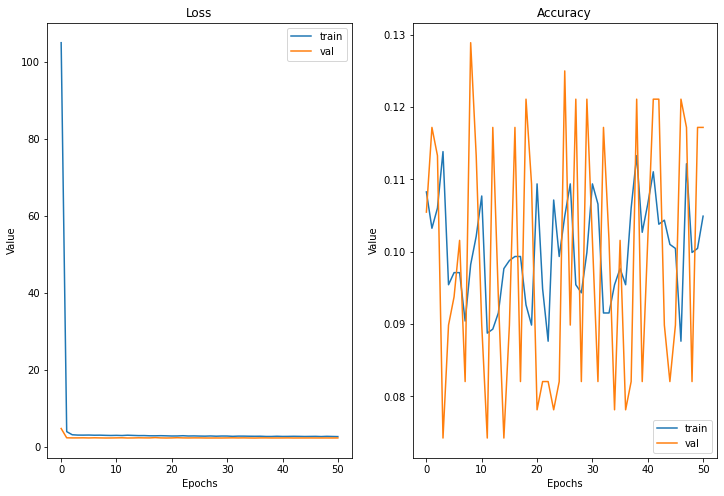

*******************number_2_kfold_model*******************
Epoch 1/500
55/56 [============================>.] - ETA: 0s - loss: 112.0123 - accuracy: 0.0977
Epoch 00001: val_loss improved from inf to 8.22006, saving model to ./model/model1_best_0.h5
56/56 [==============================] - 3s 46ms/step - loss: 110.1029 - accuracy: 0.0982 - val_loss: 8.2201 - val_accuracy: 0.1289 - lr: 0.0010
Epoch 2/500
55/56 [============================>.] - ETA: 0s - loss: 3.6194 - accuracy: 0.1102
Epoch 00002: val_loss improved from 8.22006 to 2.31734, saving model to ./model/model1_best_0.h5
56/56 [==============================] - 2s 40ms/step - loss: 3.6205 - accuracy: 0.1094 - val_loss: 2.3173 - val_accuracy: 0.1055 - lr: 0.0010
Epoch 3/500
55/56 [============================>.] - ETA: 0s - loss: 3.1203 - accuracy: 0.0881
Epoch 00003: val_loss improved from 2.31734 to 2.31528, saving model to ./model/model1_best_0.h5
56/56 [==============================] - 2s 40ms/step - loss: 3.1250 - accuracy

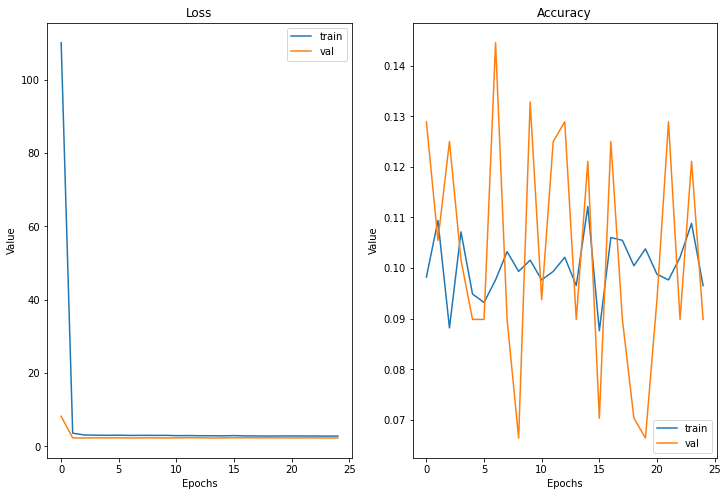

*******************number_3_kfold_model*******************
Epoch 1/500
55/56 [============================>.] - ETA: 0s - loss: 108.5439 - accuracy: 0.1000
Epoch 00001: val_loss improved from inf to 4.00303, saving model to ./model/model1_best_0.h5
56/56 [==============================] - 3s 47ms/step - loss: 106.7068 - accuracy: 0.0993 - val_loss: 4.0030 - val_accuracy: 0.1172 - lr: 0.0010
Epoch 2/500
55/56 [============================>.] - ETA: 0s - loss: 3.7327 - accuracy: 0.1097
Epoch 00002: val_loss improved from 4.00303 to 2.43198, saving model to ./model/model1_best_0.h5
56/56 [==============================] - 2s 40ms/step - loss: 3.7206 - accuracy: 0.1105 - val_loss: 2.4320 - val_accuracy: 0.1211 - lr: 0.0010
Epoch 3/500
55/56 [============================>.] - ETA: 0s - loss: 3.1908 - accuracy: 0.0852
Epoch 00003: val_loss improved from 2.43198 to 2.34883, saving model to ./model/model1_best_0.h5
56/56 [==============================] - 2s 39ms/step - loss: 3.1863 - accuracy

Epoch 28/500
55/56 [============================>.] - ETA: 0s - loss: 2.8012 - accuracy: 0.1011
Epoch 00028: val_loss did not improve from 2.31155
56/56 [==============================] - 2s 36ms/step - loss: 2.8005 - accuracy: 0.1010 - val_loss: 2.3254 - val_accuracy: 0.0977 - lr: 5.1200e-04
Epoch 29/500
55/56 [============================>.] - ETA: 0s - loss: 2.7994 - accuracy: 0.0972
Epoch 00029: val_loss did not improve from 2.31155
56/56 [==============================] - 2s 36ms/step - loss: 2.8000 - accuracy: 0.0965 - val_loss: 2.3120 - val_accuracy: 0.1172 - lr: 4.0960e-04
Epoch 30/500
55/56 [============================>.] - ETA: 0s - loss: 2.7894 - accuracy: 0.1028
Epoch 00030: val_loss did not improve from 2.31155
56/56 [==============================] - 2s 36ms/step - loss: 2.7888 - accuracy: 0.1032 - val_loss: 2.3298 - val_accuracy: 0.0859 - lr: 4.0960e-04
Epoch 31/500
55/56 [============================>.] - ETA: 0s - loss: 2.8264 - accuracy: 0.0938
Epoch 00031: val_loss 

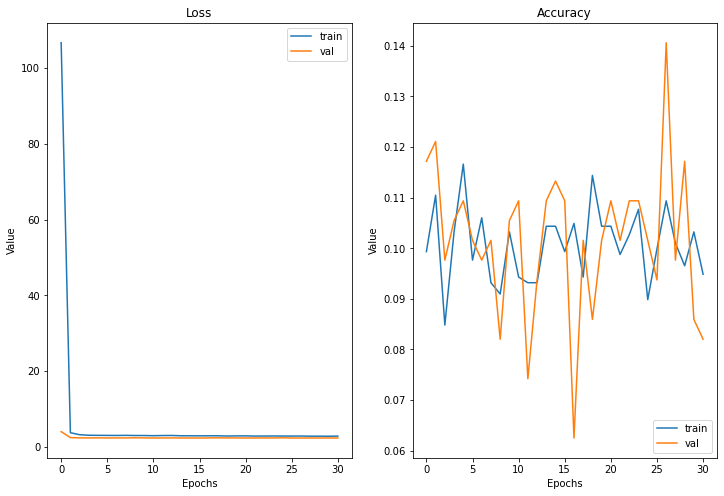

*******************number_4_kfold_model*******************
Epoch 1/500
55/56 [============================>.] - ETA: 0s - loss: 98.0589 - accuracy: 0.0966 
Epoch 00001: val_loss improved from inf to 4.55680, saving model to ./model/model1_best_0.h5
56/56 [==============================] - 2s 45ms/step - loss: 96.3861 - accuracy: 0.0977 - val_loss: 4.5568 - val_accuracy: 0.1914 - lr: 0.0010
Epoch 2/500
55/56 [============================>.] - ETA: 0s - loss: 3.7531 - accuracy: 0.1057
Epoch 00002: val_loss improved from 4.55680 to 2.42015, saving model to ./model/model1_best_0.h5
56/56 [==============================] - 2s 38ms/step - loss: 3.7444 - accuracy: 0.1060 - val_loss: 2.4201 - val_accuracy: 0.1211 - lr: 0.0010
Epoch 3/500
55/56 [============================>.] - ETA: 0s - loss: 3.1595 - accuracy: 0.0972
Epoch 00003: val_loss improved from 2.42015 to 2.30992, saving model to ./model/model1_best_0.h5
56/56 [==============================] - 2s 39ms/step - loss: 3.1437 - accuracy:

Epoch 28/500
55/56 [============================>.] - ETA: 0s - loss: 2.8284 - accuracy: 0.1057
Epoch 00028: val_loss did not improve from 2.30236
56/56 [==============================] - 2s 33ms/step - loss: 2.8257 - accuracy: 0.1060 - val_loss: 2.3064 - val_accuracy: 0.1016 - lr: 4.0960e-04
Epoch 29/500
55/56 [============================>.] - ETA: 0s - loss: 2.7983 - accuracy: 0.1028
Epoch 00029: val_loss did not improve from 2.30236
56/56 [==============================] - 2s 34ms/step - loss: 2.7974 - accuracy: 0.1027 - val_loss: 2.3439 - val_accuracy: 0.0977 - lr: 3.2768e-04
Epoch 30/500
55/56 [============================>.] - ETA: 0s - loss: 2.7566 - accuracy: 0.1034
Epoch 00030: val_loss improved from 2.30236 to 2.29404, saving model to ./model/model1_best_0.h5
56/56 [==============================] - 2s 40ms/step - loss: 2.7549 - accuracy: 0.1027 - val_loss: 2.2940 - val_accuracy: 0.1016 - lr: 3.2768e-04
Epoch 31/500
55/56 [============================>.] - ETA: 0s - loss: 2.

In [ ]:
RX_train, RX_test = get_stacking(rexnet_model, X_trains, y_trains)

## Pickle 파일 저장

In [11]:
pickle.dump(RX_train, open("./pickle/RX_train.pkl", "wb"))
pickle.dump(RX_test, open("./pickle/RX_test.pkl", "wb"))

NameError: name 'RX_train' is not defined